# FashionMNIST CNN Training and Evaluation Notebook

# This notebook demonstrates how to:

- Preprocess the FashionMNIST dataset.
- Define two CNN models (a Baseline CNN and an Improved CNN that uses Dropout and Batch Normalization).
- Train the models.
- Evaluate and visualize the results using a loss curve and a confusion matrix (with numerical annotations).

Simply run the notebook cells one by one.


In [49]:
# Imports and Device Configuration

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, random_split
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import confusion_matrix


In [50]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)


Using device: cuda


In [51]:
transform = transforms.Compose([
    transforms.ToTensor()
])

# Download and load the FashionMNIST training dataset
train_val_dataset = datasets.FashionMNIST(root='./data', train=True, download=True, transform=transform)

# Split training data: 90% for training and 10% for validation
train_size = int(0.9 * len(train_val_dataset))
val_size = len(train_val_dataset) - train_size
train_dataset, val_dataset = random_split(train_val_dataset, [train_size, val_size])

# Create DataLoaders for training and validation
batch_size = 64
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader   = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

# Download and load the FashionMNIST test dataset
test_dataset = datasets.FashionMNIST(root='./data', train=False, download=True, transform=transform)
test_loader  = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)


In [52]:
class BaselineCNN(nn.Module):
    def __init__(self):
        super(BaselineCNN, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=32, kernel_size=3)  # (28-3+1)=26x26 output
        self.relu1 = nn.ReLU()
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)                     # Reduces to 13x13

        self.conv2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3)  # (13-3+1)=11x11 output
        self.relu2 = nn.ReLU()
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)                     # Reduces to approx. 5x5

        # Fully connected layers: Flattened features: 64 channels with a 5x5 feature map gives 64*5*5 inputs.
        self.fc1 = nn.Linear(64 * 5 * 5, 128)
        self.relu3 = nn.ReLU()
        self.fc2 = nn.Linear(128, 10)  # 10 classes for FashionMNIST

    def forward(self, x):
        x = self.pool1(self.relu1(self.conv1(x)))  # Conv1 -> ReLU -> Pool
        x = self.pool2(self.relu2(self.conv2(x)))    # Conv2 -> ReLU -> Pool
        x = x.view(x.size(0), -1)                    # Flatten
        x = self.relu3(self.fc1(x))
        x = self.fc2(x)
        return x


In [59]:
class ImprovedCNN(nn.Module):
    def __init__(self):
        super(ImprovedCNN, self).__init__()
        self.conv1   = nn.Conv2d(in_channels=1, out_channels=32, kernel_size=3)
        self.bn1     = nn.BatchNorm2d(32)
        self.relu1   = nn.ReLU()
        self.pool1   = nn.MaxPool2d(kernel_size=2, stride=2)
        self.dropout1= nn.Dropout(0.25)

        self.conv2   = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3)
        self.bn2     = nn.BatchNorm2d(64)
        self.relu2   = nn.ReLU()
        self.pool2   = nn.MaxPool2d(kernel_size=2, stride=2)
        self.dropout2= nn.Dropout(0.25)

        self.fc1     = nn.Linear(64 * 5 * 5, 128)
        self.relu3   = nn.ReLU()
        self.dropout3= nn.Dropout(0.5)
        self.fc2     = nn.Linear(128, 10)

    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu1(x)
        x = self.pool1(x)
        x = self.dropout1(x)

        x = self.conv2(x)
        x = self.bn2(x)
        x = self.relu2(x)
        x = self.pool2(x)
        x = self.dropout2(x)

        x = x.view(x.size(0), -1)  # Flatten the tensor
        x = self.fc1(x)
        x = self.relu3(x)
        x = self.dropout3(x)
        x = self.fc2(x)
        return x


In [54]:
def train_model(model, optimizer, criterion, train_loader, val_loader, num_epochs, model_name="Model"):
    model.to(device)
    train_losses = []
    val_losses = []

    for epoch in range(num_epochs):
        model.train()
        epoch_train_loss = 0.0

        # Training phase
        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            epoch_train_loss += loss.item() * images.size(0)

        epoch_train_loss /= len(train_loader.dataset)
        train_losses.append(epoch_train_loss)

        # Validation phase
        model.eval()
        epoch_val_loss = 0.0
        with torch.no_grad():
            for images, labels in val_loader:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                loss = criterion(outputs, labels)
                epoch_val_loss += loss.item() * images.size(0)

        epoch_val_loss /= len(val_loader.dataset)
        val_losses.append(epoch_val_loss)

        print(f"{model_name} Epoch {epoch+1}/{num_epochs} | Training Loss: {epoch_train_loss:.4f} | Validation Loss: {epoch_val_loss:.4f}")

    # Plot loss curves
    plt.figure(figsize=(8, 5))
    plt.plot(range(1, num_epochs+1), train_losses, label='Training Loss')
    plt.plot(range(1, num_epochs+1), val_losses, label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title(f'{model_name} Loss Curves')
    plt.legend()
    plt.show()

    return model

def test_model(model, test_loader, model_name="Model"):
    model.to(device)
    model.eval()
    correct = 0
    total = 0
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    accuracy = 100 * correct / total
    print(f"{model_name} Test Accuracy: {accuracy:.2f}%")

    # Generate and plot the confusion matrix with number annotations
    cm = confusion_matrix(all_labels, all_preds)
    plt.figure(figsize=(8,6))
    plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
    plt.title(f'{model_name} Confusion Matrix')
    plt.colorbar()
    tick_marks = np.arange(10)
    plt.xticks(tick_marks, tick_marks)
    plt.yticks(tick_marks, tick_marks)
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')

    # Annotate each cell with the count value
    thresh = cm.max() / 2.0  # threshold for contrasting text color
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            plt.text(j, i, format(cm[i, j], 'd'),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")

    plt.show()

    return accuracy, cm


Training Baseline Model...
BaselineCNN Epoch 1/20 | Training Loss: 0.5364 | Validation Loss: 0.3826
BaselineCNN Epoch 2/20 | Training Loss: 0.3524 | Validation Loss: 0.3322
BaselineCNN Epoch 3/20 | Training Loss: 0.3024 | Validation Loss: 0.2957
BaselineCNN Epoch 4/20 | Training Loss: 0.2709 | Validation Loss: 0.2955
BaselineCNN Epoch 5/20 | Training Loss: 0.2426 | Validation Loss: 0.2611
BaselineCNN Epoch 6/20 | Training Loss: 0.2210 | Validation Loss: 0.2553
BaselineCNN Epoch 7/20 | Training Loss: 0.2005 | Validation Loss: 0.2616
BaselineCNN Epoch 8/20 | Training Loss: 0.1837 | Validation Loss: 0.2585
BaselineCNN Epoch 9/20 | Training Loss: 0.1673 | Validation Loss: 0.2522
BaselineCNN Epoch 10/20 | Training Loss: 0.1523 | Validation Loss: 0.2581
BaselineCNN Epoch 11/20 | Training Loss: 0.1359 | Validation Loss: 0.2511
BaselineCNN Epoch 12/20 | Training Loss: 0.1241 | Validation Loss: 0.2525
BaselineCNN Epoch 13/20 | Training Loss: 0.1135 | Validation Loss: 0.2601
BaselineCNN Epoch 14

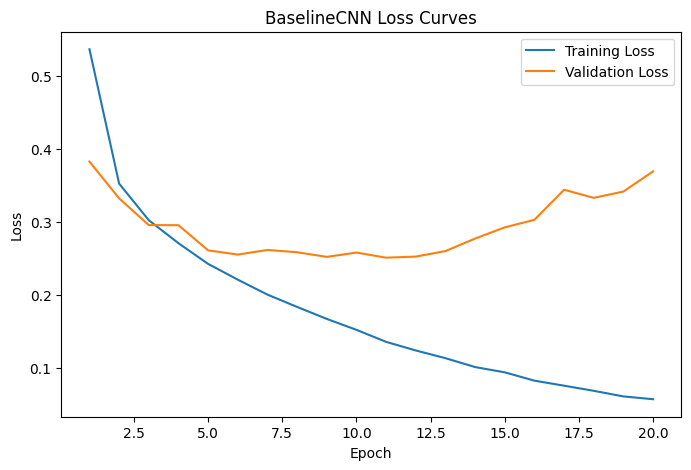

Evaluating Baseline Model on Test Data...
BaselineCNN Test Accuracy: 91.28%


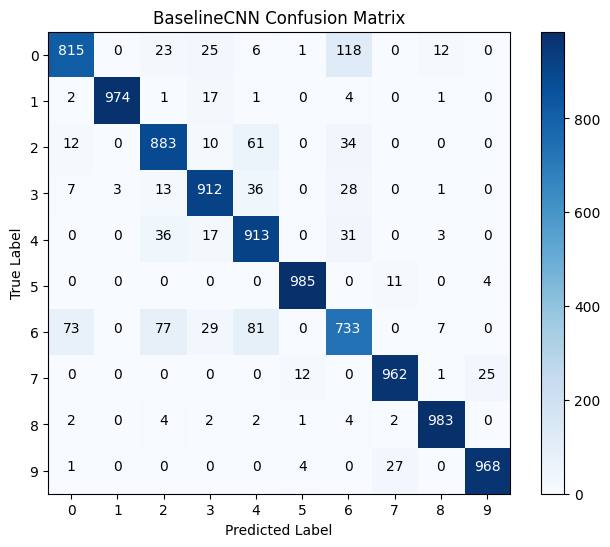

In [61]:
learning_rate = 0.001
num_epochs = 20

# Define the loss function
criterion = nn.CrossEntropyLoss()

# ----- Baseline Model -----
baseline_model = BaselineCNN()
optimizer_baseline = optim.Adam(baseline_model.parameters(), lr=learning_rate)

print("Training Baseline Model...")
baseline_model = train_model(baseline_model, optimizer_baseline, criterion, train_loader, val_loader, num_epochs, model_name="BaselineCNN")

print("Evaluating Baseline Model on Test Data...")
baseline_accuracy, baseline_cm = test_model(baseline_model, test_loader, model_name="BaselineCNN")



Training Improved Model (with Dropout and Batch Normalization)...
ImprovedCNN Epoch 1/20 | Training Loss: 0.5937 | Validation Loss: 0.3765
ImprovedCNN Epoch 2/20 | Training Loss: 0.4383 | Validation Loss: 0.3211
ImprovedCNN Epoch 3/20 | Training Loss: 0.3991 | Validation Loss: 0.2982
ImprovedCNN Epoch 4/20 | Training Loss: 0.3741 | Validation Loss: 0.2897
ImprovedCNN Epoch 5/20 | Training Loss: 0.3532 | Validation Loss: 0.2775
ImprovedCNN Epoch 6/20 | Training Loss: 0.3428 | Validation Loss: 0.2968
ImprovedCNN Epoch 7/20 | Training Loss: 0.3259 | Validation Loss: 0.2659
ImprovedCNN Epoch 8/20 | Training Loss: 0.3188 | Validation Loss: 0.2756
ImprovedCNN Epoch 9/20 | Training Loss: 0.3131 | Validation Loss: 0.2600
ImprovedCNN Epoch 10/20 | Training Loss: 0.3051 | Validation Loss: 0.2644
ImprovedCNN Epoch 11/20 | Training Loss: 0.2956 | Validation Loss: 0.2572
ImprovedCNN Epoch 12/20 | Training Loss: 0.2899 | Validation Loss: 0.2475
ImprovedCNN Epoch 13/20 | Training Loss: 0.2850 | Valid

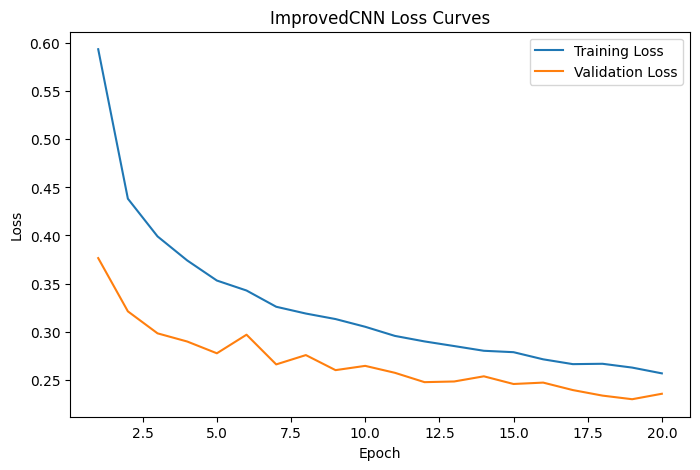

Evaluating Improved Model on Test Data...
ImprovedCNN Test Accuracy: 91.23%


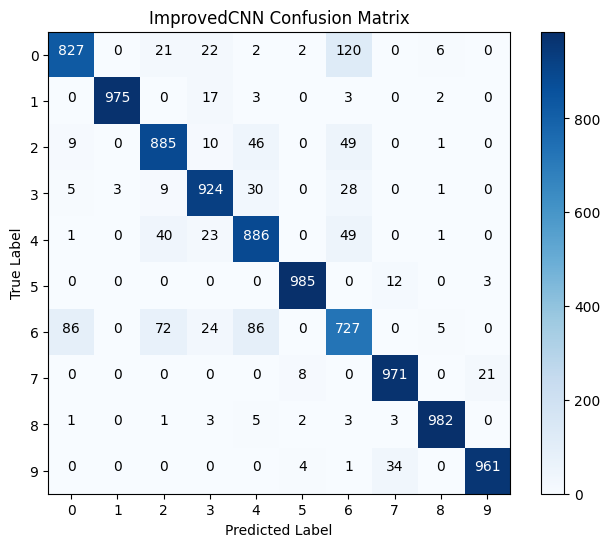

In [62]:
# ----- Improved Model (with Dropout and Batch Normalization) -----
improved_model = ImprovedCNN()
optimizer_improved = optim.Adam(improved_model.parameters(), lr=learning_rate)

print("Training Improved Model (with Dropout and Batch Normalization)...")
improved_model = train_model(improved_model, optimizer_improved, criterion, train_loader, val_loader, num_epochs, model_name="ImprovedCNN")

print("Evaluating Improved Model on Test Data...")
improved_accuracy, improved_cm = test_model(improved_model, test_loader, model_name="ImprovedCNN")
